In [1]:
# the notion of "biased coin" is ambiguous:
# 1. it could mean the coin has a specific p other than 0.5 (e.g. p=0.56)
# 2. it could mean the coin have any p other than 0.5, all these values are equally likely
#
# the two notions are different for that the first dictates that a coin has a specific bias,
# whereas the second notion assumes all possible biases has the same probability and then
# consider the posterior of seeing the result.

import numpy as np
import pandas as pd
from empiricaldist import Pmf
from scipy.stats import binom

# now let's analysize the likelihoods, P(result | presupposition) for each presupposition where result is {140H in 250 clips}.
#
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_unfair = binom.pmf(k, n, p=0.56)
biased_dist = Pmf(1, np.linspace(0, 1, 101))
biased_dist[0.5] = 0
biased_dist.normalize()
biased_dist *= binom.pmf(k, n, p=biased_dist.qs)
like_biased = biased_dist.sum()
print(like_fair, like_unfair, like_biased)

0.008357181724918188 0.05077815959518337 0.0039004919277707355


0.006981325464857881


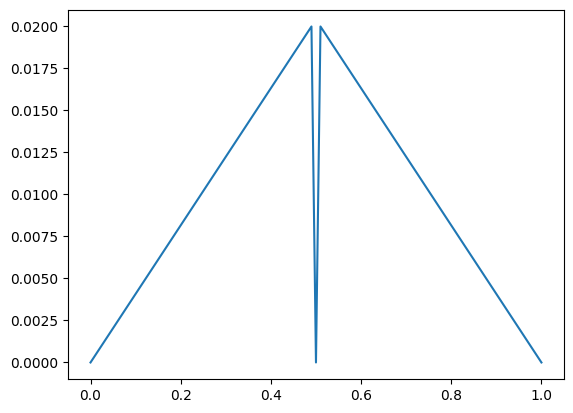

In [2]:
# another presupposition is that the dice may be biased but more likely biased at the middle (close to p=0.5).
# i.e. it's less likely to be p=0.1 than p=0.6. for this we can use a triangular shape distribution as our prior biased distribution.
trig_biased_dist = Pmf(list(range(50)) + list(range(50, -1, -1)), biased_dist.qs)
trig_biased_dist[0.5] = 0
trig_biased_dist.normalize()
trig_biased_dist.plot()
trig_biased_dist *= binom.pmf(k, n, p=trig_biased_dist.qs)
like_biased_trig = trig_biased_dist.sum()
print(like_biased_trig)

,likelihoood,compare to fair
Fair,0.008357,1.000000
p=0.56,0.050778,6.075991
Evenly biased,0.003900,0.466723
Trigly biased,0.006981,0.835368


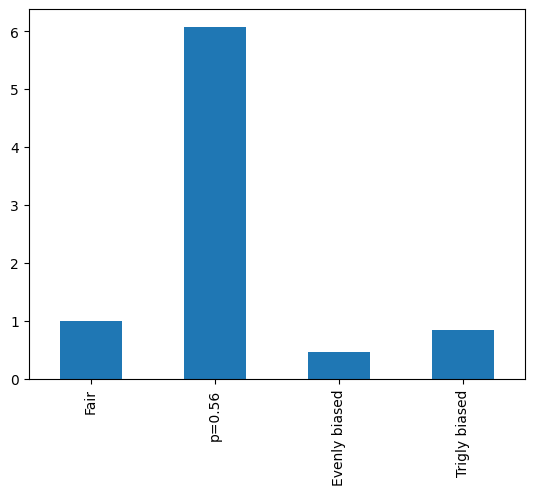

In [3]:
df = pd.DataFrame()
df.index = ['Fair', 'p=0.56', 'Evenly biased', 'Trigly biased']
df['likelihoood'] = [like_fair, like_unfair, like_biased, like_biased_trig]
df['compare to fair'] = df['likelihoood'] / df['likelihoood']['Fair']
df['compare to fair'].plot(kind='bar')
df

Above analysis shows the procedure of what's called "Bayesian hypothesis testing", in contrast to the widely used "Statistical hypothesis testing".
In short, instead of giving out a p-value for how statistically significant is the hypothesis,
we give out the likelihood (Bayesian factor) for one theory against others. This method avoids dispute on the arbitrary prior
(which hypos are more likely). However, calculating each Bayesian factor, we still need a precise and sometimes arbitrary definition
of the hypothesis, which on its own is still disputable.

The author's opinion is that despite the room for controversy, the Bayesian method is still superior because it talks about
the "strength of an evidence" instead of "probability of a theory is true", yielding a continuum instead of a binary assertion. The usefulness comes from the ability to make prediction and make decision:

- Prediction: Based on what we know about the coin, what should we expect to happen in the future?
- Decision making: Can we make use the prediction to make better decisions?

Comparing it to the knowledge of the "truthfulness" of a particularly hypothesis. From the perspective of usefulness, the Bayesian method is already useful.

[36, 13, 204, 747]
360


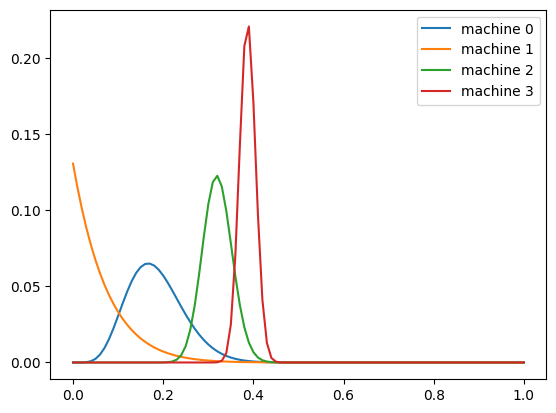

In [69]:
# one-armed bandit and bayesian method
#
# suppose there are N one-armed bandits, each with an internal winnning rate of p_i,
# if you are to play M times with no prior knowledge about the machines,
# what's your strategy to win the most.


def simulate_bandits(true_probs, n_times):
    # we don't know the probability of the slot machine, so we assume any probability is equally likely
    uniform_prior = Pmf(1, np.linspace(0, 1, 101))
    uniform_prior.normalize()
    priors = [Pmf(uniform_prior.copy()) for _ in true_probs]
    chooses = [0 for _ in true_probs]
    winning = 0

    for _ in range(n_times):
        chosen = np.argmax([b.choice() for b in priors])
        chooses[chosen] += 1
        result = 'W' if np.random.random() < true_probs[chosen] else 'L'
        if result == 'W':
            priors[chosen] *= priors[chosen].qs
            winning += 1
        else:
            priors[chosen] *= 1 - priors[chosen].qs
        priors[chosen].normalize()
    return (priors, chooses, winning)

(bs, c, w) = simulate_bandits([0.1, 0.2, 0.3, 0.4], 1000)
for i, b in enumerate(bs):
    b.plot(label=f"machine {i}", legend=True)

print(c)
print(w)

In [71]:
# SAT Adaptive testing problem: the goal of SAT test is to find the true ability of test takers.
#
# the (simplified) standard SAT test gives 100 problems to the test taker, and the score is the percentage of
# the problem answered correctly.
#
# now there is a computerized version of SAT called adaptive testing. If test taker answers the first few
# questions right, it presents harder questions, and if the test taker answers them wrong, it presents easier
# problems.
#
# model these two tests. answer whether the adaptive version is more "efficient".

# we suppose the questions can have difficulty 0.0-1.0. Let's model the correctness using a sigmoid function on
# the difference between the ability and problem difficulty.
def prob_correct(difficulty, ability):
    z = (ability - difficulty) * 10
    # scale it up a bit to exaggerate the probability of answering correctly or incorrectly
    return 1/(1 + np.exp(-z))
def try_answer(difficulty, ability):
    return np.random.random() < prob_correct(difficulty, ability)

# standard version:
def standard_naive(n_questions, ability):
    questions = np.linspace(0.1, 1.0, n_questions)
    score = 0
    for q in questions:
        if try_answer(q, ability):
            score += 1
    return score

print(standard_naive(100, 0.7))

70


0.681007108282484 0.030813334305918563


<Axes: >

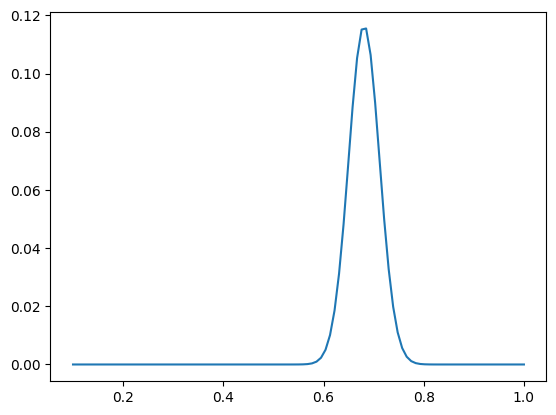

In [82]:
# but we can do better to give a distribution on the user's ability
def standard_bayesian(n_questions, ability):
    questions = np.linspace(0.1, 1.0, n_questions)
    prior = Pmf(1, np.linspace(0.1, 1.0, 101))
    score = 0
    for q in questions:
        if try_answer(q, ability):
            prior *= prob_correct(q, prior.qs)
        else:
            prior *= 1 - prob_correct(q, prior.qs)
    prior.normalize()
    return prior

posterior = standard_bayesian(100, 0.7)
print(posterior.mean(), posterior.std())
posterior.plot()

0.7204581786133203 0.022259642857387824


<Axes: >

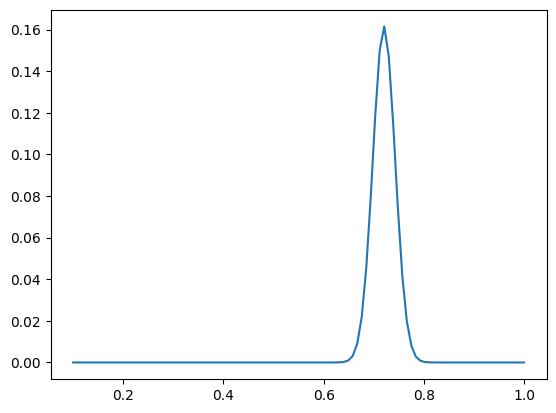

In [92]:
# now the adaptive version. It's vague in exactly what the adaptive mechanism mean.
# let's assume an extremely simple adaptive mechanism. for each correct answer,
# we increase difficulty by 0.1, for every wrong answer, we decrease difficulty by 0.1.
# Let's try again.

def adaptive_bayesian(n_questions, ability):
    questions = []
    q = 0.5
    prior = Pmf(1, np.linspace(0.1, 1.0, 101))
    for _ in range(n_questions):
        if try_answer(q, ability):
            prior *= prob_correct(q, prior.qs)
            q = min(q + 0.1, 1.0)
        else:
            prior *= 1 - prob_correct(q, prior.qs)
            q = max(q - 0.1, 0.5)
    prior.normalize()
    return prior

posterior = adaptive_bayesian(100, 0.7)
print(posterior.mean(), posterior.std())
posterior.plot()

0.6878181602372626 0.020656493592809265


<Axes: >

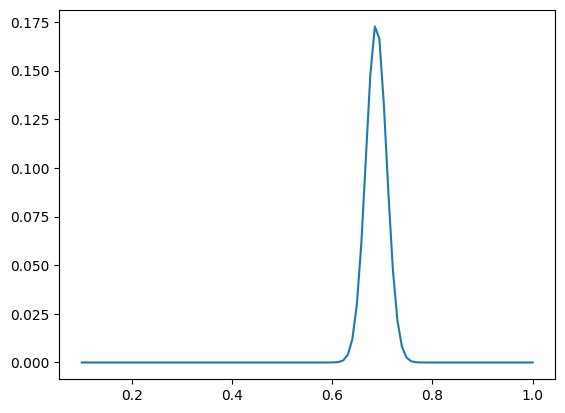

In [107]:
# we can see the adaptive version is indeed better based on the lower std (0.022 vs 0.031).
#
# I just thought of another adaptive mechanism. Every time we give problem, we give it out of the difficulty matching
# our the information about the ability of the student.

def adaptive_bayesian_v2(n_questions, ability):
    questions = []
    prior = Pmf(1, np.linspace(0.1, 1.0, 101))
    prior.normalize()
    for _ in range(n_questions):
        q = prior.sample()
        if try_answer(q, ability):
            prior *= prob_correct(q, prior.qs)
        else:
            prior *= 1 - prob_correct(q, prior.qs)
        prior.normalize()
    return prior

posterior = adaptive_bayesian_v2(100, 0.7)
print(posterior.mean(), posterior.std()) # this method has lower std (0.021 vs 0.022).
posterior.plot()

0.717377771072335 0.02042457875930824


<Axes: >

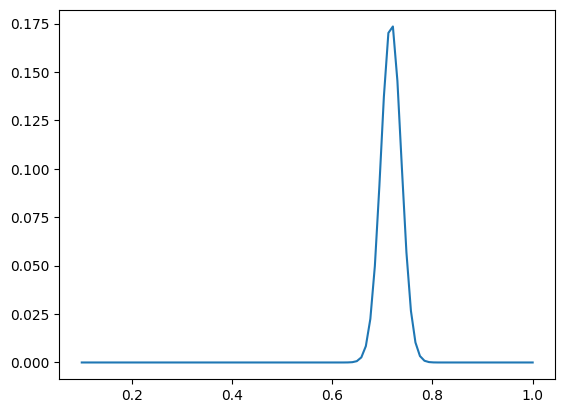

In [106]:
# the third version I can think of is to skip the sampling, just give out
# questions at the student's estimated ability.
#
# I expect this to perform similarly to the sampled method because it's
# similar to what the user 
def adaptive_bayesian_v3(n_questions, ability):
    questions = []
    prior = Pmf(1, np.linspace(0.1, 1.0, 101))
    prior.normalize()
    for _ in range(n_questions):
        q = prior.idxmax()
        if try_answer(q, ability):
            prior *= prob_correct(q, prior.qs)
        else:
            prior *= 1 - prob_correct(q, prior.qs)
        prior.normalize()
    return prior

posterior = adaptive_bayesian_v3(100, 0.7)
print(posterior.mean(), posterior.std()) # this method has lower std (0.022 vs 0.031).
posterior.plot()